In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

import scipy.optimize, scipy.stats
import pandas as pd

## Parameter uncertainty

#### Just how confident are you in your parameter values, anyway?

You measure an observable over time and would like to extract a rate constant $k$ for the process.  You are fitting the data using the code below. Each data point was measured independently of the others.  

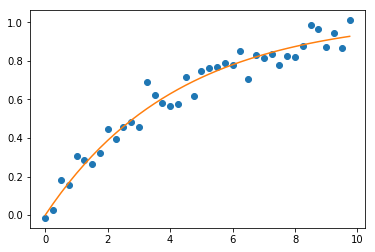

In [2]:
def first_order(t,A,k):
    """
    First-order kinetics model. 
    """
    
    return A*(1 - np.exp(-k*t))

def first_order_r(param,t,obs):
    """
    Residuals function for first-order model.
    """
    return first_order(t,param[0],param[1]) - obs

def fit_model(t,obs,param_guesses=(1,1)):
    """
    Fit the first-order model.
    """

    fit = scipy.optimize.least_squares(first_order_r,
                                       param_guesses,
                                       args=(t,obs))
    fit_A = fit.x[0]
    fit_k = fit.x[1]

    return fit_A, fit_k

d = pd.read_csv("data/time_course_0.csv")
A, k = fit_model(d.t,d.obs)
plt.plot(d.t,d.obs,'o')
plt.plot(d.t,first_order(d.t,A,k))

In [3]:
### CELL FOR CREATING DATA


def create_data(t,k,A,out_file="junk.csv",noise=None):

    write_noise = False
    if noise == None:
        noise = 0
    elif type(noise) == float:
        noise = np.random.normal(0,noise,len(t))
    else:
        write_noise = True
        nosie = noise
        
    obs = first_order(t,A,k) + noise

    plt.plot(t,obs,"o")

    if not write_noise:
        d = pd.DataFrame({"t":t,"obs":obs})
    else:
        d = pd.DataFrame({"t":t,"obs":obs,"obs_err":np.abs(noise)})
        
    d.to_csv(out_file)

    
#t = np.arange(0,10,0.25)
#create_data(t,0.25,1.0,"data/time_course_0.csv",0.05)
#create_data(t,0.35,1.0,"data/time_course_1.csv",0.05)
#create_data(t,0.25,1.0,"data/time_course_2.csv",np.random.normal(0,0.05,len(t)))
#create_data(t,0.25,1.0,"data/time_course_3.csv",np.random.normal(0,0.05,len(t)))
#create_data(t,0.25,1.0,"data/time_course_4.csv",np.random.normal(0,0.05,len(t)))


+ Your uncertainty in each measured point is normally distributed with a standard deviation of 0.05. Use a simulation to create a histogram of possible values for $A$ and $k$. (Hint: you'll want to fit a whole bunch of times).  You can create the individual histograms using `plt.histogram`.  If you want to show off, make a 2D histogram (good discussion of how to do this [here](https://stackoverflow.com/questions/27156381/python-creating-a-2d-histogram-from-a-numpy-matrix)). 

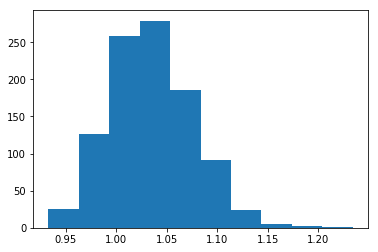

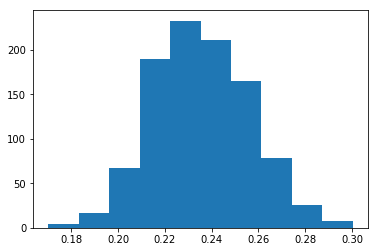

In [4]:
d = pd.read_csv("data/time_course_0.csv")

A_list = []
k_list = []
for i in range(1000):
    A, k = fit_model(d.t,d.obs + np.random.normal(0,0.05,len(d.t)))
    A_list.append(A)
    k_list.append(k)

plt.hist(A_list)
plt.show()

plt.hist(k_list)
plt.show()
    

+ What are the 95% confidence intervals on your estimate of $k$?  The lower bound is the value of $k$ for which 2.5% of the histogram counts are below the value.  The upper bound is the value of $k$ for which 2.5% of the histogram counts are above the value.

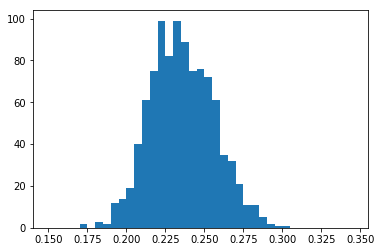

0.197293987943 0.235792302486 0.278434647091


In [5]:
k_list.sort()               # Sort from low to high
lower = k_list[25]         # Lower 25
upper = k_list[1000-25]   # Upper 25

plt.hist(k_list,bins=np.arange(0.15,0.35,0.005))
plt.show()

print(lower,np.mean(k_list),upper)

+ You measure the same process under slightly different conditions.  These data are stored in `data/time_course_1.csv`.  Is there a statistically significant difference between $k$ from dataset 1 vs. 0?

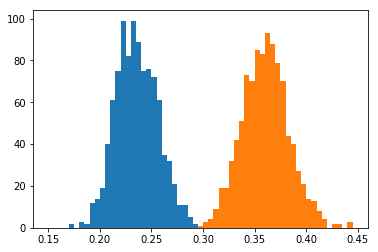

0.197293987943 0.235792302486 0.278434647091
0.317304581349 0.360582232958 0.374962543798


In [6]:
d = pd.read_csv("data/time_course_1.csv")

A1_list = []
k1_list = []
for i in range(1000):
    A, k = fit_model(d.t,d.obs + np.random.normal(0,0.05,len(d.t)))
    A1_list.append(A)
    k1_list.append(k)

plt.hist(k_list,bins=np.arange(0.15,0.35,0.005))
plt.hist(k1_list,bins=np.arange(0.25,0.45,0.005))
plt.show()

k1_list.sort()
lower1 = k1_list[25]
upper1 = k1_list[1000-250]

print(lower,np.mean(k_list),upper)
print(lower1,np.mean(k1_list),upper1)

# 95% confidence intervals do not overlap.  Can be distinguished. 

### Bonus: 
These are a couple of challenge questions for students who are already comfortable fitting and want to extend this basic fitting example. 

+ You repeat the experiment again and explicitly measure the variance of each point (meaning some are now 0.1, others 0.3, etc.).  These values are stored in `data/time_course_2.csv` in the `obs_err` column.  Modify your sampling code so you incorporate these point-specific uncertainties. 

+ "Global fitting" is a powerful way to squeeze the most information out of experiments.  Rather than fitting models to individual experimental replicates and then estimating parameter uncertainty, one can fit all experiments at once to extract a single estimate of the fit parameters.  Implement a global fit function that simultaneously fits the data in `data/time_course_2.csv`, `data/time_course_3.csv`, and `data/time_course_4.csv`, then report your estimate and 95% confidence intervals of $k$. Do your confidence intervals change with more data?

## Model selection

#### How do you choose which model to use? 

The Akaike Information Criterion (AIC) helps you select between competing models.  It penalizes models for the number of fittable parameters because adding parameters will almost always make a fit better.   

$$AIC = -2ln(\hat{L}) + 2k$$

where $\hat{L}$ is the "maximum likelihood" and $k$ is (1 + number of fittable parameters in the model).  $\hat{L}$ is proportional to the sum of the squared residuals ($SSR$), so we can write:

$$ AIC = nln(SSR) + 2k $$ 

where $n$ is the number of observations. If we want to compare $N$ different models, we first normalize $AIC$ for each model as $\Delta _{i}$. 

$$\Delta _{i} = AIC_{i} - AIC_{min}$$ 

where $AIC_{min}$ is the best AIC.  The support for a given model is given by the Akaike weight ($w$):

$$w_{i} = \frac{exp(-\Delta_{i}/2)}{\sum_{j=0}^{j<N} exp(-\Delta_{j}/2)}$$

The weight runs from 0.0 to 1.0, with 1.0 representing the strongest support.  For a more thorough description, see [here](http://www.sortie-nd.org/lme/Statistical%20Papers/Burnham_and_Anderson_2004_Multimodel_Inference.pdf).

+ Create a function called **`calc_aic`** that returns the Akaike weight for a list of models.  **`calc_aic`** should take the following arguments:
    + list of ssr for each fit
    + list of num_parameters for each fit
    + number of observations you fit the models to
    
#### You can check your function with the following lists.  

In [7]:
# these values
ssr_list = [0.05,0.001,0.00095]
num_parameters = [2,3,10]
num_obs = 10

# should give these weights
weights = [8.69e-9,0.9988,1.18e-3]

In [8]:
def calc_aic(ssr_list,k_list,num_obs):
    
    aic_list = []
    for i in range(len(ssr_list)):
        aic_list.append(num_obs*np.log(ssr_list[i]) + 2*(k_list[i] + 1))
    
    aic_list = np.array(aic_list)
    delta_list = aic_list - np.min(aic_list)
    
    Q = np.exp(-delta_list/2)
    return Q/np.sum(Q)

weights = calc_aic(ssr_list,num_parameters,num_obs)
print(weights)

[  8.68826287e-09   9.98822903e-01   1.17708843e-03]


## Real example: what can you learn from your data?

Sedimentation equilibrium experiments are used to study molecular assemblies.  If spin a solution of molecules in a centrifuge very fast for a very long time, you get an equlibirum distribution of molecules along the length ($r$) of the tube.  This is because centrigual force pulls them to the bottom of the tube, while diffusion tends to spread them out over the tube.  If you measure the concentration of molecules along the length of the tube $c(r)$, you can then fit a model and  back out the molecular weight(s) of the species in solution. 

The equation describing a simple, non-interacting molecule is below.  $c_{0}$ is the concentration of the molecule at $r=0$, $M$ is the molecular weight of the molecule, and $r$ is the position along the tube. 

$$c(r) = c_{0}exp \Big [ M \Big ( \frac{r^{2}}{2} \Big ) \Big ]$$

You are interested in whether there is any dimer present (a dimer is a pair of interacting molecules).  If there is dimer, our model gets more complicated.  We have to add a term $\theta$ that describes the fraction of the molecules in dimer versus monomer:

$$c(r) = c_{0} \Big ( \theta exp \Big [ M \Big ( \frac{r^{2}}{2} \Big ) \Big ] + (1 - \theta )exp \Big [ 2M \Big ( \frac{r^{2}}{2} \Big ) \Big ] \Big )$$


(I've collapsed in a bunch of constants to simplify the problem. If you want a full discussion of the method, see [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2711687/), particularly equation 4). 

#### Main question: do these data provide evidence for a dimer?




+ Implement a function and residuals function for each of these models. The first model should have the fittable parameters $c_{0}$ and $M$.  The second model should have the fittable parameters $c_{0}$, $M$, and $\theta$.  

In [9]:
def residuals(params,r,c,f):
    """
    General residuals function.
    """
    
    return f(r,*params) - c

def sed_eq_m(r,c0,M):
    
    return c0*np.exp(M*(r**2)/2)

def sed_eq_md(r,c0,M,theta):
    
    return c0*((theta)*np.exp(M*(r**2)/2) + (1 - theta)*np.exp(2*M*(r**2)/2))


+ Fit both models to the data in `data/sed_eq.csv`.  What are your estimates of $c_{0}$, $M$, and $\theta$?  Are they the same between the two fits?

In [10]:
## CREATE DATA CELL

#r = np.linspace(0,1,100)
#c0 = 1.0
#M = 2
#theta = 0.95

#md = pd.DataFrame({"r":r,"c":sed_eq_md(r,c0,M,theta)+ np.random.normal(0,0.025,len(r))})
#md.to_csv("dev/md.csv")

monomer: 0.0211731680092 [ 0.99503142  2.15964313] 100
monomer/dimer 0.0205784296649 [ 0.99860086  2.05310987  0.96923224] 100


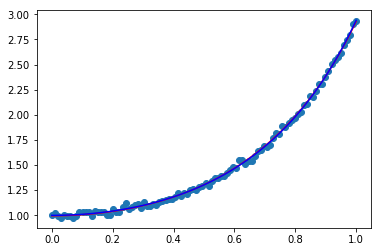

In [11]:
d = pd.read_csv("data/sed_eq.csv")

plt.plot(d.r, d.c,"o")

fit_m = scipy.optimize.least_squares(residuals,
                                   (1,2),
                                   kwargs={"r":d.r,
                                           "c":d.c,
                                           "f":sed_eq_m})
print("monomer:",fit_m.cost,fit_m.x,len(fit_m.fun))

plt.plot(d.r,sed_eq_m(d.r,fit_m.x[0],fit_m.x[1]),color="red")

fit_md = scipy.optimize.least_squares(residuals,
                                   (1,2.0,0.95),
                                   kwargs={"r":d.r,
                                           "c":d.c,
                                           "f":sed_eq_md})
print("monomer/dimer",fit_md.cost,fit_md.x,len(fit_md.fun))
plt.plot(d.r,sed_eq_md(d.r,fit_md.x[0],fit_md.x[1],fit_md.x[2]),color="blue")

+ Use your `calc_aic` function on these fits. Which model is supported?  Can you conclude there is dimer present?

In [12]:
calc_aic([0.0211731680092,0.0205784296649],[2,3],100)

array([ 0.39542494,  0.60457506])

## Gaussian

One common type of data is a sum of Gaussian functions.  Among other places, these sort of data pop up in single-molecule work, fluorescence-activated cell sorting, spectroscopy and chromatography.  You collect a dataset that looks like the following:

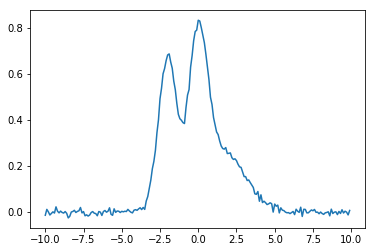

In [13]:
d = pd.read_csv("data/gaussian.csv")
plt.plot(d.x,d.y)

You find code to analyze this kind of data on the internet.  Using the functions below, determine:

+ how many gaussians you can extract from the data  in `lab-data/gaussian.csv`.
+ their means, standard deviations, and areas. 

**PS: you should play with your initial guesses**
**PPS: negative area gaussians are not allowed**

In [14]:
def multi_gaussian(x,means,stds,areas):
    """
    Function calculating multiple gaussians (built from
    values in means, stds, areas).  The number of gaussians
    is determined by the length of means, stds, and areas.
    The gaussian functions are calculated at values in
    array x. 
    """
    
    if len(means) != len(stds) or len(means) != len(areas):
        err = "means, standard deviations and areas should have the same length!\n"
        raise ValueError(err)
    
    out = np.zeros(len(x),dtype=float)
    for i in range(len(means)):
        out += areas[i]*scipy.stats.norm(means[i],stds[i]).pdf(x)

    return out

def multi_gaussian_r(params,x,y):
    """
    Residuals function for multi_guassian. 
    """
    
    params = np.array(params)
    if params.shape[0] % 3 != 0:
        err = "num parameters must be divisible by 3\n"
        raise ValueError(err)
    
    means = params[np.arange(0,len(params),3)]
    stds = params[np.arange(1,len(params),3)]
    areas = params[np.arange(2,len(params),3)]
    
    return multi_gaussian(x,means,stds,areas) - y



def fitter(x,y,means_guess,stds_guess,areas_guess):
    """
    Fit an arbitrary number of gaussian functions to x/y data.
    The number of gaussians that will be fit is determined by
    the length of means_guess.  
    
    x: measurement x-values (array)
    y: measurement y-values (array)
    means_guess: array of guesses for means for gaussians.  
                 length determines number of gaussians
    stds_guess: array of guesses of standard deviations for
                gaussians. length must match means_guess
    areas_guess: array of area guesses for gaussians.  
                 length must match means guess.
                 
    returns: means, stds, areas and fit sum-of-squared-residuals
    """
    
    # Sanity check
    if len(means_guess) != len(stds_guess) or len(means_guess) != len(areas_guess):
        err = "means, standard deviations and areas should have the same length!\n"
        raise ValueError(err)
    
    # Construct an array of parameter guesses by assembling
    # means, stds, and areas
    param_guesses = []
    for i in range(len(means_guess)):
        param_guesses.append(means_guess[i])
        param_guesses.append(stds_guess[i])
        param_guesses.append(areas_guess[i])
    param_guesses = np.array(param_guesses)
    
    # Fit the multigaussian function
    fit = scipy.optimize.least_squares(multi_gaussian_r,param_guesses,
                                       args=(x,y))
    
    # Disassemble into means, stds, areas
    means = fit.x[np.arange(0,len(fit.x),3)]
    stds = fit.x[np.arange(1,len(fit.x),3)]
    areas = fit.x[np.arange(2,len(fit.x),3)]
    
    return means, stds, areas, fit.cost
    
def plot_gaussians(means,stds,areas):
    """
    Plot a collection of gaussians.
    
    means: array of means for gaussians.  
           length determines number of gaussians
    stds: array of standard deviations for gaussians.
          length must match means_guess
    areas: array of areas for gaussians.  
           length must match means guess.
    """
    
    plt.plot(d.x,multi_gaussian(d.x,means,stds,areas))

    for i in range(len(means)):
        plt.plot(d.x,multi_gaussian(d.x,
                                    [means[i]],
                                    [stds[i]],
                                    [areas[i]]))
        

In [15]:
## CREATE DATA

#x = np.arange(-10,10,0.1)
#means = np.array((-2,0,1.5))
#stds = np.array((0.6,.6,1.5))
#areas = np.array((1,1,1))

#d = pd.DataFrame({"x":np.arange(-10,10,0.1),
#                  "y":multi_gaussian(x,means,stds,areas)+np.random.normal(0,0.01,len(x))})

#d.to_csv("dev/gaussian.csv")

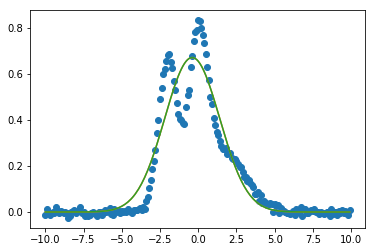

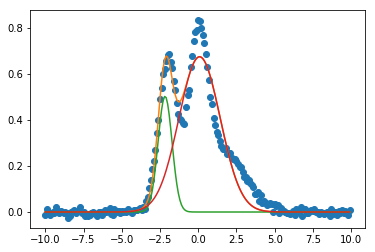

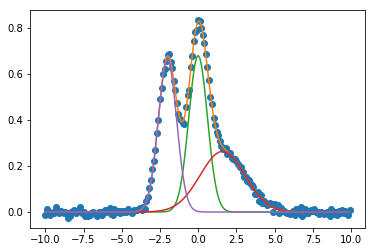

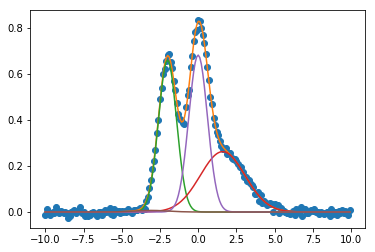

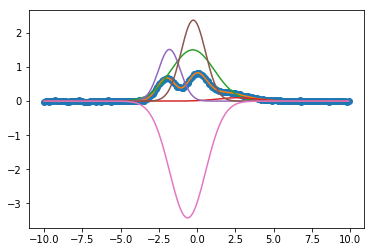

[  3.73423322e-178   4.33712456e-142   5.96228240e-001   1.29431295e-001
   2.74340465e-001]


In [16]:
d = pd.read_csv("data/gaussian.csv")

ssr_list = []
num_params = []
for i in range(1,6):

    means_guess = np.random.normal(0.1,1,i) #np.ones(i,dtype=float)
    stds_guess = np.ones(i,dtype=float)
    areas_guess = np.ones(i,dtype=float)

    fit_means, fit_stds, fit_areas, ssr = fitter(d.x,d.y,means_guess,stds_guess,areas_guess)

    plt.plot(d.x,d.y,"o")
    plot_gaussians(fit_means,fit_stds,fit_areas)
    plt.show()
    
    ssr_list.append(ssr)
    num_params.append((i+1)*3)
    
len(d.x)

print(calc_aic(ssr_list,num_params,len(d.x)))